In [294]:
from acquire import get_telco_data
from prepare import train_validate_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import explore
from scipy import stats

In [313]:
df = get_telco_data()

Using cached data


# Prepare Exploration (Pre-split)

In [314]:
# Initially drop redundant columns
df = df.drop(columns = ['payment_type_id','internet_service_type_id','contract_type_id'])

# From prior exploration of dataset a small number of the total_charges are just whitespace - these are all new customers who haven't been with the company for >1 month.
# Given that it is a very small proportion of the total dataset these rows will be deleted for ease of computation later on
(df == " ").sum()

df = df.drop(df[df.total_charges == " "].index)

# Confirm no more blanks
(df == " ").sum().sum()

# Confirm no nulls
(df.isna().sum()).sum()

# Convert total_charges to float for later analysis
df.total_charges = df.total_charges.astype('float64')

# Confirm dtypes
df.dtypes

customer_id               object
gender                    object
senior_citizen             int64
partner                   object
dependents                object
tenure                     int64
phone_service             object
multiple_lines            object
online_security           object
online_backup             object
device_protection         object
tech_support              object
streaming_tv              object
streaming_movies          object
paperless_billing         object
monthly_charges          float64
total_charges            float64
churn                     object
contract_type             object
internet_service_type     object
payment_type              object
dtype: object

In [324]:
df.has_internet_service.value_counts()

1    5512
0    1520
Name: has_internet_service, dtype: int64

In [316]:
df = df.rename(columns={'senior_citizen':'is_senior_citizen'})
df.churn = df.churn.map({'Yes':1,'No':0})
df['is_male'] = df.gender.map({'Male':1,'Female':0})
df['has_phone'] = df.phone_service.map({'Yes':1,'No':0})
df['has_internet_service'] = df.internet_service_type.map({'Fiber optic':1,'DSL':1,'None':0})
df['has_partner']= df.partner.map({'Yes':1,'No':0})
df['has_dependent'] = df.dependents.map({'Yes':1,'No':0})
df['is_paperless'] = df.paperless_billing.map({'Yes':1,'No':0})
df['is_month_to_month'] = df.contract_type.map({'Two year':0,'One year':0, 'Month-to-month':1})
df['is_autopay'] = df.payment_type.map({'Electronic check': 0, 'Mailed check': 0, 'Bank transfer (automatic)':1, 'Credit card (automatic)': 1})

In [317]:
df.columns

Index(['customer_id', 'gender', 'is_senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type', 'is_male', 'has_phone', 'has_internet_service',
       'has_partner', 'has_dependent', 'is_paperless', 'is_month_to_month',
       'is_autopay'],
      dtype='object')

In [318]:
# # Determine the categorical variables - here defined as object data type (non-numeric) and with fewer than 5 values
# catcol = df.columns[(df.nunique()<5)&(df.dtypes == 'object')]
# # Encode categoricals
# dummy_df = pd.get_dummies(df[catcol], dummy_na=False, drop_first=True)
# # Concatenate dummy df to original df
# df = pd.concat([df,dummy_df],axis=1)
# # Remove the original categorical columns after encoding
# df = df.drop(columns=catcol)

# Exploration (Post-split)

### Question to explore:
    - Do any groups churn at higher than the overall average rate? YES
    - Do any groups churn at lower than the overall average rate? YES
    - For the month to month plan - do churners pay more than non churners? YES
    - Of the groups that churn at higher than overall average, do any particular sub groups churn higher? Internet customers - Fiber
    - Within the sub groups do any specific options lead to higher churn? NO for fiber non streamer
    
    
    - Which groups make the most money for the company? Any above the overall average?
    - Do any of these groups align with the the groups that churn the most? With the least churn rate?
 
    

In [319]:
train, validate, test = train_validate_test_split(df, target = 'churn', seed =123)

In [320]:
train.shape, validate.shape, test.shape

((3937, 29), (1688, 29), (1407, 29))

In [403]:
# Baseline churn rate
baseline_churn = (train.churn == 1).mean()

## Do any groups churn at rates significantly above or below the overall (baseline) mean?

### Groups defined as:
    - senior citizen
    - male vs female
    - partner vs no partner
    - dependent vs no dependent
    - Auto vs manual payers
    - Paperless billing vs not
    - Month to month vs long term
    - Internet service or not
    - Phone service or not

    
### Will perform chi square test
#### Enough samples to assume normal distribution
    

In [322]:
alpha = 0.05

In [323]:
train.columns

Index(['customer_id', 'gender', 'is_senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type', 'is_male', 'has_phone', 'has_internet_service',
       'has_partner', 'has_dependent', 'is_paperless', 'is_month_to_month',
       'is_autopay'],
      dtype='object')

In [525]:
groups = ['is_male', 'is_senior_citizen', 'has_partner', 'has_dependent', 'is_paperless','is_autopay','is_month_to_month','has_phone','has_internet_service']
ts={}
p_over_2s={}
churn_rate = {}

for group in groups:
    t, p = stats.ttest_1samp(train.churn[train[group] == 1], train.churn.mean())
    print(f'For {group} {p/2} {t}')
    
    ts[group] = t
    p_over_2s[group] = p/2
    churn_rate[group] = (train.churn[train[group] == 1]).mean()

results = pd.DataFrame(data = [ts, p_over_2s,churn_rate], index= ['t','p_over_2','churn_rate']).T

results['significantly_greater'] = (results.p_over_2<alpha) & (results.t>0)
results['significantly_lower'] = (results.p_over_2<alpha) & (results.t<0)
results['significant'] = (results.significantly_greater) | (results.significantly_lower)
results = results.sort_values(by = 'churn_rate')

For is_male 0.4998503909528952 0.0003750617495743298
For is_senior_citizen 6.657399538355316e-16 8.200566219243903
For has_partner 8.13331609478488e-13 -7.110579138485949
For has_dependent 1.0112048946230359e-24 -10.427077128848588
For is_paperless 6.257952653084417e-13 7.139016011077522
For is_autopay 9.41555705559799e-28 -11.041538009099208
For is_month_to_month 2.0592279592357914e-50 15.27620998607843
For has_phone 0.37969038010059053 0.30631757033098383
For has_internet_service 7.104763737818995e-11 6.435707727568809


In [616]:
groups = ['is_male', 'is_senior_citizen', 'has_partner', 'has_dependent', 'is_paperless','is_autopay','is_month_to_month','has_phone','has_internet_service']
reject_null = []
churn_rate=[]
for group in groups:
    observed = pd.crosstab(train.churn, train[group])
    chi2, p, dof, expected = stats.chi2_contingency(observed)
    print(group)
    # print('Observed\n')
    # print(observed.values)
    # print('---\nExpected\n')
    # print(expected.astype(int))
    # print('---\n')
    # print(f'chi^2 = {chi2:.4f}')
    # print(f'p     = {p:.4f}')
    if p < alpha:
        print("We reject the null hypothesis")
    else:
        print("We fail to reject the null hypothesis")
    churn_rate.append((train.churn[train[group] == 1]).mean())
    reject_null.append(p<alpha)
    
results = pd.DataFrame(data = {'churn_rate':churn_rate,'reject_null':reject_null},index = groups)
results = results.sort_values(by= 'churn_rate')
        

is_male
We fail to reject the null hypothesis
is_senior_citizen
We reject the null hypothesis
has_partner
We reject the null hypothesis
has_dependent
We reject the null hypothesis
is_paperless
We reject the null hypothesis
is_autopay
We reject the null hypothesis
is_month_to_month
We reject the null hypothesis
has_phone
We fail to reject the null hypothesis
has_internet_service
We reject the null hypothesis


In [540]:
results

,churn_rate,reject_null
has_dependent,0.156040,True
is_autopay,0.167331,True
has_partner,0.200524,True
is_male,0.265688,False
has_phone,0.267957,False
has_internet_service,0.319870,True
is_paperless,0.335628,True
is_senior_citizen,0.426772,True
is_month_to_month,0.428176,True


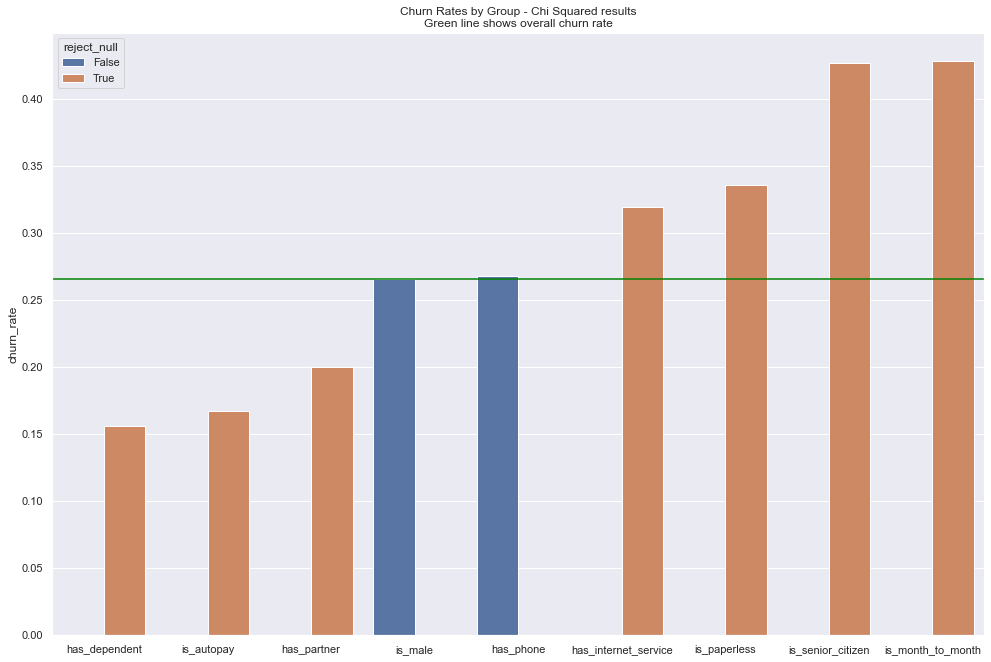

In [551]:
sns.set(rc={'figure.figsize':(14,9)})
sns.barplot(data = results, x = results.index ,y = 'churn_rate', hue = 'reject_null')
plt.tight_layout()
plt.title('Churn Rates by Group - Chi Squared results\nGreen line shows overall churn rate')
plt.axhline(y=baseline_churn, color = 'green')
# plt.bar_label(splot.containers[0])

## Four groups churn at rates significantly higher than the overall mean:
    - Senior citizens: 43%
    - Paperless billing: 34%
    - Month to Month: 43%
    - Those with internet service: 32%

# Do the churners on the month to month plan pay higher per month on average than those who don't churn on month to month?
### Perform independent t test 2 sample

- $H_0$ Those who churn on month to month plan pay the same or less as those who don't churn on month to month
- $H_a$ Those who churn on month to month plan pay more than those who don't churn

In [692]:
churn_sample = train[train.is_month_to_month == 1].monthly_charges

In [693]:
non_churn_sample = train[train.is_month_to_month == 0].monthly_charges

In [703]:
# check for equal variances
t, p = stats.levene(churn_sample, non_churn_sample)

In [704]:
t, p

(163.51485216543205, 1.0291156241073953e-36)

In [696]:
t, p = stats.ttest_ind(churn_sample, non_churn_sample, equal_var=False)

In [698]:
t,p

(2.7380394089814692, 0.006212670228116539)

In [699]:
p<alpha

True

In [700]:
t>0

True

Text(0, 0.5, 'Average monthly charge ($)')

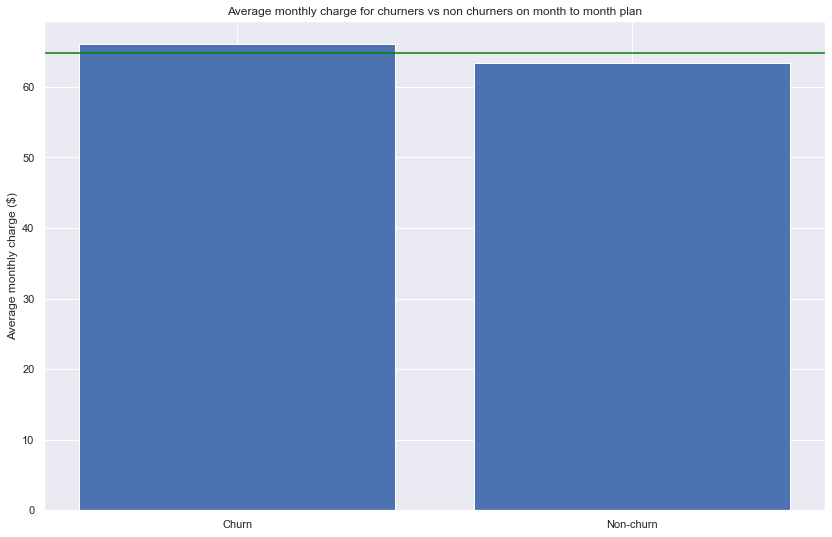

In [720]:
plt.bar(x=['Churn','Non-churn'], height =[churn_sample.mean(),non_churn_sample.mean()])
plt.title('Average monthly charge for churners vs non churners on month to month plan')
plt.axhline(train.monthly_charges.mean(), color = 'green')
plt.ylabel('Average monthly charge ($)')

## Churners on month to month pay more than non churners

# Of the groups that churn at higher than overall average, do any particular sub groups churn higher? Chi Square test
    - Focus on internet customers: Fiber vs DSL

In [721]:
# DF of just internet customers from train
internet = train[train.has_internet_service == 1]

observed = pd.crosstab(internet.churn, internet.internet_service_type)

observed

internet_service_type,DSL,Fiber optic
churn,,
0,1101,987
1,247,735


In [722]:
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [723]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Observed

[[1101  987]
 [ 247  735]]
---
Expected

[[ 916 1171]
 [ 431  550]]
---

chi^2 = 205.1136
p     = 0.0000
We reject the null hypothesis


In [724]:

expected_df = pd.DataFrame(expected,index=[0,1], columns=['DSL','Fiber optic'])
expected_dsl_churn = expected_df['DSL'].iloc[1]/expected_df['DSL'].sum()
expected_fiber_churn = expected_df['Fiber optic'].iloc[1]/expected_df['Fiber optic'].sum()
observed_dsl_churn = observed['DSL'].iloc[1]/observed['DSL'].sum()
observed_fiber_churn = observed['Fiber optic'].iloc[1]/observed['Fiber optic'].sum()

expected_dsl_churn, expected_fiber_churn, observed_dsl_churn, observed_fiber_churn

(0.31986970684039084,
 0.3198697068403909,
 0.18323442136498516,
 0.4268292682926829)

### Churn and the type of internet service are not independent.
### We expect the following churn %:
    - DSL: 432/(432+917) = 32%
    - Fiber: 551/(551+1171) = 32 %
### Actual churn %:
    - DSL: 247/(247+1101) = 14%
    - Fiber: 735/(735+987) = 42%
    

# Fiber customers churn 10% higher than expected

<AxesSubplot:xlabel='internet_service_type'>

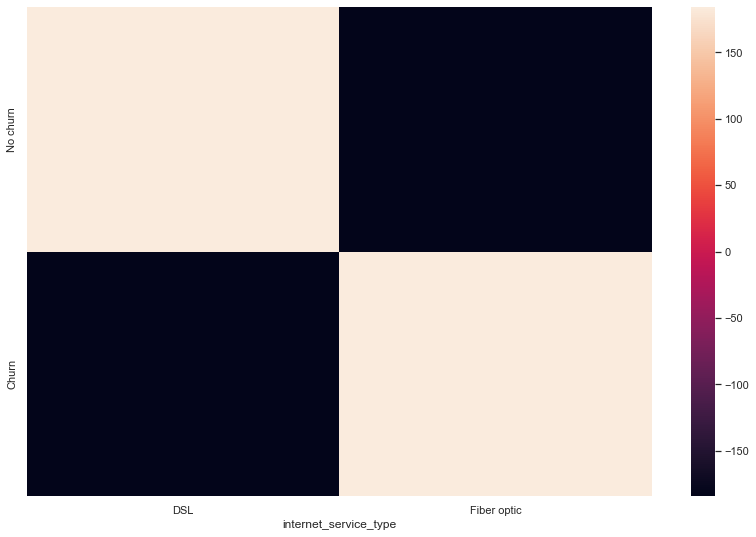

In [739]:
observed.index.name=""
expected_df = pd.DataFrame(expected,index=[0,1], columns=['DSL','Fiber optic'])
observed - expected_df
sns.heatmap(data = observed-expected_df, yticklabels=['No churn','Churn'])

### Within fiber customers - is there a particular option that is resulting in greater or less churn?

#### Looking at the internet service group, there are several options:
    - Streaming TV
    - Streaming movies
    - Tech support
    - Online security
    - Device protection
    - Online backup
### Is whether a fiber customer churns independent of the options he or she has?

In [454]:
# create df of train customers who are fiber internet
fiber = train[train.internet_service_type == 'Fiber optic']

In [455]:
# plenty of samples
fiber.shape

(1722, 29)

In [456]:
fiber.columns

Index(['customer_id', 'gender', 'is_senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type', 'is_male', 'has_phone', 'has_internet_service',
       'has_partner', 'has_dependent', 'is_paperless', 'is_month_to_month',
       'is_autopay'],
      dtype='object')

## First testing whether having streaming or not makes a difference. Is the churn rate of those fiber customers with streaming signicantly higher than the fiber average? 
### Use a chi square test

In [751]:
# Sets this variable to whether has any form of streaming (or both)
fiber['has_streaming'] = ((fiber.streaming_movies == 'Yes')|(fiber.streaming_tv == 'Yes'))

/var/folders/tt/99v8dp0d60sfw82fs51dhr4m0000gn/T/ipykernel_39583/1400377631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fiber['has_streaming'] = ((fiber.streaming_movies == 'Yes')|(fiber.streaming_tv == 'Yes'))


In [752]:
fiber.has_streaming.sum()

1222

In [753]:
(fiber.churn[fiber.has_streaming]).mean()

0.395253682487725

In [754]:
fiber.has_streaming.value_counts()

True     1222
False     500
Name: has_streaming, dtype: int64

In [755]:
fiber.churn.value_counts()

0    987
1    735
Name: churn, dtype: int64

In [756]:

observed = pd.crosstab(fiber.churn, fiber.has_streaming)
chi2, p, dof, expected = stats.chi2_contingency(observed)

print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
# churn_rate.append((train.churn[train[group] == 1]).mean())
# reject_null.append(p<alpha)
    
# results = pd.DataFrame(data = {'churn_rate':churn_rate,'reject_null':reject_null},index = groups)
# results = results.sort_values(by= 'churn_rate')


Observed

[[248 739]
 [252 483]]
---
Expected

[[286 700]
 [213 521]]
---

chi^2 = 16.7098
p     = 0.0000
We reject the null hypothesis


- $H_0$: churn is independent of whether fiber customer has streaming or not
- $H_a$: churn is not independent of whether fiber customer has streaming or not

In [757]:
print(f"Fiber streaming churn rate: {(fiber.churn[fiber.has_streaming]).mean()}")
print(f"Fiber non-streaming churn rate: {(fiber.churn[~fiber.has_streaming]).mean()}")
print(f"Overall fiber churn rate: {(fiber.churn.mean())}")
print(f"Overall churn for all customers {train.churn.mean()}")



Fiber streaming churn rate: 0.395253682487725
Fiber non-streaming churn rate: 0.504
Overall fiber churn rate: 0.4268292682926829
Overall churn for all customers 0.2656845313690627


In [758]:
observed

has_streaming,False,True
churn,,
0,248,739
1,252,483


## We reject the null hypothesis that churn is independent of whether the fiber customer is streaming or not. The churn rate of fiber customers with streaming is lower than the average fiber customer. Customers seem to be happy with our streaming service. The churn rate of non-streaming customers is actually higher than average!

### looking at the non-streamers - is there a specific option that leads to lower churn rate? Will check using chi squared

In [645]:
fiber_non_streamers = fiber[~fiber.has_streaming]

In [646]:
fiber_non_streamers.shape

(500, 30)

In [647]:
internet_options = ['online_security',
       'online_backup', 'device_protection', 'tech_support']

In [648]:
fiber_non_streamers[internet_options].value_counts()

online_security  online_backup  device_protection  tech_support
No               No             No                 No              219
                 Yes            No                 No               65
                 No             Yes                No               46
Yes              No             No                 No               28
No               Yes            Yes                No               25
Yes              Yes            Yes                No               18
No               Yes            Yes                Yes              15
Yes              Yes            No                 No               15
No               No             Yes                Yes              13
Yes              No             Yes                No               13
No               No             No                 Yes              11
Yes              Yes            No                 Yes              11
No               Yes            No                 Yes               6
Yes          

### Independent samples to compare churn rates between them. Will consider the following:
    - Online backup only
    - Device protection only
    - Online security only
    - Tech support only

In [649]:
# encode option variables
to_binary_dict = {'Yes':1,'No':0}
fiber_non_streamers[['online_security','online_backup','device_protection','tech_support']] = fiber_non_streamers[['online_security','online_backup','device_protection','tech_support']].applymap(to_binary_dict.get)

In [650]:
fiber_non_streamers['online_security_only'] = ((fiber_non_streamers.online_security == 1)&(fiber_non_streamers[['online_security','online_backup','device_protection','tech_support']].sum(axis=1)==1))
fiber_non_streamers['device_protection_only'] = ((fiber_non_streamers.device_protection == 1)&(fiber_non_streamers[['online_security','online_backup','device_protection','tech_support']].sum(axis=1)==1))
fiber_non_streamers['tech_support_only'] = ((fiber_non_streamers.tech_support == 1)&(fiber_non_streamers[['online_security','online_backup','device_protection','tech_support']].sum(axis=1)==1))
fiber_non_streamers['online_backup_only'] = ((fiber_non_streamers.online_backup == 1)&(fiber_non_streamers[['online_security','online_backup','device_protection','tech_support']].sum(axis=1)==1))

/var/folders/tt/99v8dp0d60sfw82fs51dhr4m0000gn/T/ipykernel_39583/3590322596.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fiber_non_streamers['online_security_only'] = ((fiber_non_streamers.online_security == 1)&(fiber_non_streamers[['online_security','online_backup','device_protection','tech_support']].sum(axis=1)==1))
/var/folders/tt/99v8dp0d60sfw82fs51dhr4m0000gn/T/ipykernel_39583/3590322596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fiber_non_streamers['device_protection_only'] = ((fiber_

In [654]:
internet_options = ['online_security_only',
       'online_backup_only', 'device_protection_only', 'tech_support_only']
reject_null = []
churn_rate=[]

for option in internet_options:
    observed = pd.crosstab(fiber_non_streamers.churn, fiber_non_streamers[option])
    chi2, p, dof, expected = stats.chi2_contingency(observed)
    print(option)
    print('Observed\n')
    print(observed.values)
    print('---\nExpected\n')
    print(expected.astype(int))
    print('---\n')
    print(f'chi^2 = {chi2:.4f}')
    print(f'p     = {p:.4f}')
    if p < alpha:
        print("We reject the null hypothesis")
    else:
        print("We fail to reject the null hypothesis")
    churn_rate.append((fiber_non_streamers.churn[fiber_non_streamers[option] == 1]).mean())
    reject_null.append(p<alpha)
    
results = pd.DataFrame(data = {'churn_rate':churn_rate,'reject_null':reject_null},index = internet_options)
results = results.sort_values(by= 'churn_rate')

online_security_only
Observed

[[230  18]
 [242  10]]
---
Expected

[[234  13]
 [237  14]]
---

chi^2 = 1.9745
p     = 0.1600
We fail to reject the null hypothesis
online_backup_only
Observed

[[220  28]
 [215  37]]
---
Expected

[[215  32]
 [219  32]]
---

chi^2 = 0.9895
p     = 0.3199
We fail to reject the null hypothesis
device_protection_only
Observed

[[225  23]
 [229  23]]
---
Expected

[[225  22]
 [228  23]]
---

chi^2 = 0.0000
p     = 1.0000
We fail to reject the null hypothesis
tech_support_only
Observed

[[242   6]
 [247   5]]
---
Expected

[[242   5]
 [246   5]]
---

chi^2 = 0.0007
p     = 0.9786
We fail to reject the null hypothesis


In [655]:
results

,churn_rate,reject_null
online_security_only,0.357143,False
tech_support_only,0.454545,False
device_protection_only,0.500000,False
online_backup_only,0.569231,False


In [657]:
baseline_churn = (fiber_non_streamers.churn == 1).mean()

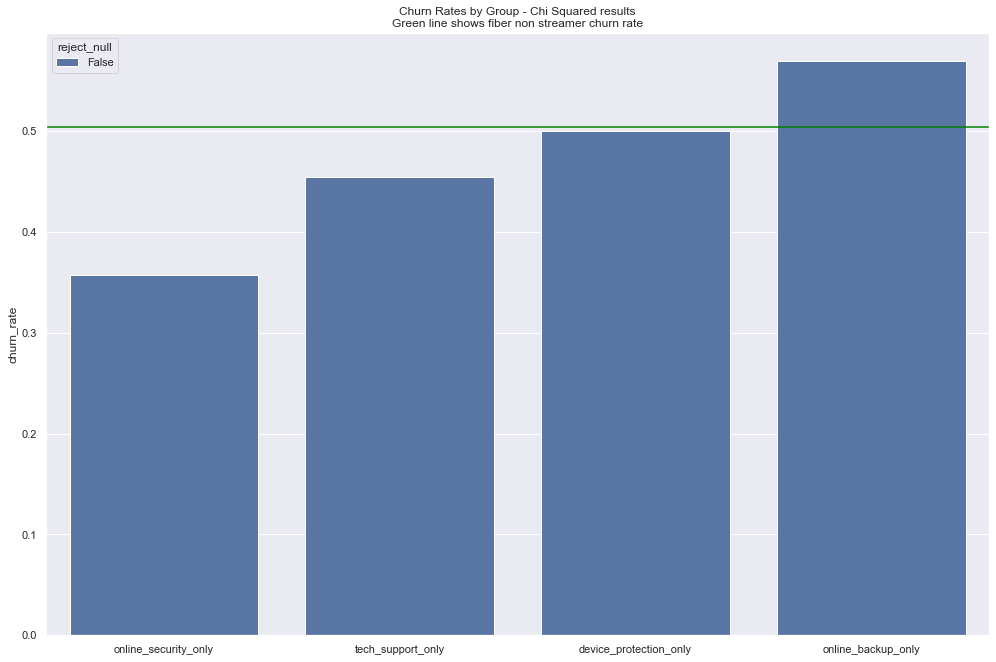

In [659]:
sns.set(rc={'figure.figsize':(14,9)})
sns.barplot(data = results, x = results.index ,y = 'churn_rate', hue = 'reject_null')
plt.tight_layout()
plt.title('Churn Rates by Group - Chi Squared results\nGreen line shows fiber non streamer churn rate')
plt.axhline(y=baseline_churn, color = 'green')
# plt.bar_label(splot.containers[0])

### We cannot reject the null hypothesis for any of the options alone. Seems to imply that whether a customer churns or not is independent of which options they have!

## Do non streaming fiber customers who churn pay more than those who don't churn?

### Will do a two sample t - test
 - $H_0$ non streaming churners pay on average the same or less than that of non streaming non-churners
 - $H_a$ non streaming churners pay on average more than non streaming non-churners

In [661]:
fiber_streamers = fiber[fiber.has_streaming]

In [670]:
# performe a levene test to check for equal variances
# H0 : variances are equal
# HAL variances not equal
stat, p = stats.levene(fiber_non_streamers[fiber_non_streamers.churn==1].monthly_charges, fiber_non_streamers[fiber_non_streamers.churn==0].monthly_charges)

In [671]:
p<alpha

True

In [672]:
# reject null -variances are not equal
fiber_non_streamers[fiber_non_streamers.churn==1].monthly_charges.var()

24.953417125150185

In [673]:
fiber_non_streamers[fiber_non_streamers.churn==0].monthly_charges.var()

45.476457979626495

In [675]:
t, p = stats.ttest_ind(fiber_non_streamers[fiber_non_streamers.churn==1].monthly_charges, fiber_non_streamers[fiber_non_streamers.churn==0].monthly_charges,equal_var=False)
t, p/2

(-6.649883914355402, 4.2124135327910584e-11)

In [682]:
print(f"Average monthly charge for churning non streaming fiber customers :{fiber_non_streamers[fiber_non_streamers.churn==1].monthly_charges.mean()}")
print(f"Average monthly charge for non churning non streaming fiber customers :{fiber_non_streamers[fiber_non_streamers.churn==0].monthly_charges.mean()}")

Average monthly charge for churning non streaming fiber customers :75.47063492063492
Average monthly charge for non churning non streaming fiber customers :79.00443548387099


## p/2 is less than alpha but t is > 0 , so we fail to reject the null hypothesis
## Non streaming fiber churners do not pay more than streaming churners!!

# Is there a significant difference in churn between non streaming fiber customers vs dsl customers? 

## Categorical variables

### Takeaways:
- Evenly distributed by gender and partner
- Two broad categories lead to subcategories that would be worthwhile to look at individually:
    - Phone service or not: 
        - Multiple lines
    - Internet Service or not:
        - online security
        - online backup
        - tech support
        - device protection
        - streaming tv
        - streaming movies
        - service type (DSL vs Fiber)
     

In [19]:
target = 'churn'

In [12]:
catcol

Index(['gender', 'partner', 'dependents', 'phone_service', 'multiple_lines',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'paperless_billing', 'churn',
       'contract_type', 'internet_service_type', 'payment_type'],
      dtype='object')

In [30]:
train['partner']

5310    Yes
3790    Yes
4398    Yes
2635     No
2986    Yes
       ... 
6230    Yes
356      No
2128    Yes
3586     No
6817    Yes
Name: partner, Length: 3943, dtype: object